In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

## Options

In [2]:
# parse options
problem = 'twelve_pieces_process.json' # 'pavilion_process.json' # 'twelve_pieces_process.json'
problem_subdir = 'results'

recompute_action_states = False
load_external_movements = False

In [3]:
from collections import namedtuple
PlanningArguments = namedtuple('PlanningArguments', ['problem', 'viewer', 'debug', 'diagnosis', 'id_only', 'solve_mode', 'viz_upon_found', 
                                             'save_now', 'write', 'plan_impacted', 'watch', 'step_sim', 'verbose'])
# args = PlanningArguments(problem, viewer, debug, diagnosis, id_only, solve_mode, viz_upon_found, save_now, write, plan_impacted, watch, step_sim, verbose)

## Parse process from json

In [4]:
import os
from termcolor import cprint
import pybullet_planning as pp
from integral_timber_joints.planning.parsing import parse_process, save_process_and_movements, get_process_path, save_process

pybullet build time: May  8 2021 05:48:13


In [9]:
process = parse_process(problem, subdir=problem_subdir)
result_path = get_process_path(problem, subdir='results')
if len(process.movements) == 0:
    cprint('No movements found in process, trigger recompute actions.', 'red')
    recompute_action_states = True
if recompute_action_states:
    cprint('Recomputing Actions and States', 'cyan')
    recompute_action_states(process)

Process json parsed from /home/yijiangh/itj_ws/integral_timber_joints/external/itj_design_study/210128_RemodelFredPavilion/results/twelve_pieces_process.json


In [64]:
# from collections import defaultdict
import json

file_name = 'b4_runtime_data_No_TC_21-07-05_19-59-42.json'
runtime_data = {}
with open('figs/{}'.format(file_name), 'r') as f:
    runtime_data = json.load(f)

print(runtime_data.keys())

dict_keys(['nonlinear', 'linear_forward', 'linear_backward'])


# Diagram

In [65]:
# ['nonlinear', 'linear_forward', 'linear_backward']
for solve_mode_ in runtime_data:
    print('='*20)
    for i, tdata in runtime_data[solve_mode_].items():
        print('#{}-T#{}:'.format(solve_mode_, i))
        sc = any([d['success'] for di, d in tdata.items()])
        
        total_runtime = []
        for i, trial_data in tdata.items():
            trial_profiles = trial_data['profiles']
            runtime_per_move = [sum(trial_profiles[mid]['plan_time']) for mid in trial_profiles]
            total_runtime.append(sum(runtime_per_move))
        tdata['total_runtime'] = sum(total_runtime)
        cprint('{} - BT {} | time {:.2f}'.format(sc, len(tdata), sum(total_runtime)), 'green' if sc else 'red')
        print('---')

#nonlinear-T#0:
True - BT 4 | time 421.48
---
#nonlinear-T#1:
True - BT 2 | time 139.53
---
#nonlinear-T#2:
True - BT 7 | time 710.07
---
#nonlinear-T#3:
True - BT 5 | time 353.05
---
#nonlinear-T#4:
True - BT 2 | time 225.53
---
#nonlinear-T#5:
True - BT 2 | time 115.46
---
#nonlinear-T#6:
True - BT 2 | time 96.72
---
#nonlinear-T#7:
False - BT 5 | time 642.98
---
#nonlinear-T#8:
True - BT 7 | time 527.44
---
#nonlinear-T#9:
True - BT 2 | time 153.19
---
#linear_forward-T#0:
False - BT 5 | time 619.62
---
#linear_forward-T#1:
False - BT 5 | time 631.76
---
#linear_forward-T#2:
True - BT 5 | time 371.83
---
#linear_forward-T#3:
True - BT 4 | time 279.41
---
#linear_forward-T#4:
False - BT 7 | time 670.53
---
#linear_forward-T#5:
False - BT 8 | time 648.69
---
#linear_forward-T#6:
True - BT 5 | time 502.75
---
#linear_forward-T#7:
True - BT 4 | time 574.00
---
#linear_forward-T#8:
False - BT 9 | time 617.66
---
#linear_forward-T#9:
True - BT 5 | time 467.00
---
#linear_backward-T#0:
Fal

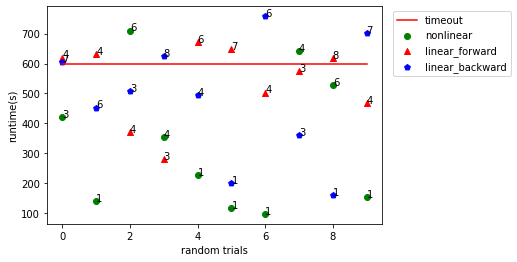

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np

fig, ax = plt.subplots()
markers = ['o', '^', (5, 0)]
mcolors = ['g', 'r', 'b']
for marker, mcolor, (solve_m, solve_mode_data) in zip(markers, mcolors, runtime_data.items()):
    x = range(len(solve_mode_data))
    runtime_per_trial = [solve_mode_data[str(at)]['total_runtime'] for at in x]
    num_bts = [len(solve_mode_data[str(at)])-1 for at in x]
    plt.scatter(x, runtime_per_trial, marker=marker, c=mcolor, label=solve_m)
    for i in x:
        plt.annotate(num_bts[i], (i, runtime_per_trial[i]))
plt.plot(x, [600 for _ in x], c='r', label='timeout')
        
ax.set_xlabel('random trials')
ax.set_ylabel('runtime(s)')
# ax.set_title('Runtime by sovl')
leg = ax.legend(loc='upper right')

plt.draw() # Draw the figure so you can find the positon of the legend. 

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())

# Change to location of the legend. 
xOffset = 0.4
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

plt.show()

# Detailed diagram

In [31]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from integral_timber_joints.process import RoboticFreeMovement, RoboticLinearMovement, RoboticClampSyncLinearMovement

# solve_mode_ = 'linear_forward' # linear_backward | linear_forward | nonlinear
beam_id = file_name.split('_runtime_data')[0]

# total_rows = 0
# for i, d in runtime_data[solve_mode_].items():
#     total_rows += len(d)+1
max_inner_loop_displayed = 6

for solve_mode_ in runtime_data:
    for attempt_i, s_rdata in runtime_data[solve_mode_].items():
        if 'total_runtime' in s_rdata:
            del s_rdata['total_runtime']
        if len(s_rdata) > max_inner_loop_displayed:
            num_rows = max_inner_loop_displayed+1
            half = int(max_inner_loop_displayed/2)
            selected_inners = list(range(0,half)) + list(range(len(s_rdata)-half,len(s_rdata)))
        else:
            num_rows = len(s_rdata)+1
            selected_inners = list(range(len(s_rdata)))

        fig = make_subplots(rows=num_rows, cols=2)
        success = any([d['success'] for di, d in s_rdata.items()])
        total_runtime = []
        failed_m_id = []
        for i in s_rdata.keys():
            trial_data = s_rdata[i]
            trial_profiles = trial_data['profiles']
            mid_keys = sorted(trial_profiles.keys(), key=int)
            runtime_per_move = [sum(trial_profiles[mid]['plan_time']) for mid in mid_keys]
            total_runtime.append(sum(runtime_per_move))

            for mid in mid_keys:
                if not any(trial_profiles[mid]['plan_success']):
                    movement = process.get_movement_by_movement_id(trial_profiles[mid]['movement_id'][0])
                    m_color = '#ff1b6b' if isinstance(movement, RoboticFreeMovement) else '#45caff'
                    failed_m_id.append((mid, movement.short_summary, m_color))
                    break
            else:
                failed_m_id.append((-1, 'success!', '#00ff87'))

            if i in selected_inners or int(i) in selected_inners:
                success_colors = ['#99C24D' if any(trial_profiles[mid]['plan_success']) else '#F18F01' for mid in mid_keys]
                row_id = selected_inners.index(int(i))+1
                fig.append_trace(go.Scatter(x=mid_keys,
                                        y=runtime_per_move,
                                        mode='markers',
                                        marker_color=success_colors,
                                        text=[process.get_movement_by_movement_id(trial_profiles[mid]['movement_id'][0]).short_summary \
                                              for mid in mid_keys], # hover text goes here
                                        name='#{}-feasibility'.format(i),
                                        ),
                              row=row_id, col=1
                            )

                fig.append_trace(go.Scatter(x=mid_keys,
                                                y=runtime_per_move,
                                                mode='markers',
                                                    marker=dict(
                                                    size=5,
                                                    color=[trial_profiles[mid]['sample_order'][0] for mid in mid_keys], #set color equal to a variable
                                                    colorscale='Viridis', # one of plotly colorscales
                                                    showscale=True
                                                ),
                                                text=['S#{}-{}'.format(trial_profiles[mid]['sample_order'][0], process.get_movement_by_movement_id(trial_profiles[mid]['movement_id'][0]).short_summary) \
                                                      for mid in mid_keys], # hover text goes here
                                                name='#{}-sample order'.format(i),),
                              row=row_id, col=2
                                )
                if row_id == 1:
                    fig.update_xaxes(title_text="m_id",row=row_id, col=1)
                    fig.update_yaxes(title_text="runtime(s)",row=row_id, col=1)

        fig.append_trace(go.Scatter(x=list(range(len(s_rdata))),y=total_runtime), 
                         row=num_rows, col=1)
        fig.update_xaxes(title_text="trials",row=num_rows, col=1)
        fig.update_yaxes(title_text="runtime(s)",row=num_rows, col=1)

        fig.append_trace(go.Scatter(x=list(range(len(failed_m_id))),y=[int(tt[0]) for tt in failed_m_id],
                                    mode='markers',
                                    marker_color=[tt[2] for tt in failed_m_id],
                                    text=[tt[1] for tt in failed_m_id],
                                   ), row=num_rows, col=2)
        fig.update_xaxes(title_text="trials",row=num_rows, col=2)
        fig.update_yaxes(title_text="failed_movement_id",row=num_rows, col=2)


        title = "figs/{}-{}-trail_{}_success-{}_BT-{}_time-{:.1f}".format(beam_id, solve_mode_, 
            attempt_i, success, len(s_rdata), sum(total_runtime))
        fig.update_layout(title=title)
        fig.write_html(title + ".html")
# fig.show()

In [41]:
len(failed_m_id)

207

# Save runtime data

In [106]:
runtime_data.keys()

dict_keys(['linear', 'nonlinear'])

## Start client

In [10]:
from integral_timber_joints.planning.robot_setup import load_RFL_world
from integral_timber_joints.planning.run import set_initial_state

# * Connect to path planning backend and initialize robot parameters
# viewer or diagnosis or view_states or watch or step_sim,
client, robot, _ = load_RFL_world(viewer=False, verbose=False)
set_initial_state(client, robot, process, disable_env=disable_env, reinit_tool=False)

argv[0]=
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
x_railb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
robot11_tool0b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
robot12_tool0b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/Bull

In [32]:
client.disconnect()

# Visualize traj

In [17]:
from integral_timber_joints.planning.state import set_state
from integral_timber_joints.planning.visualization import visualize_movement_trajectory

altered_ms = [process.get_movement_by_movement_id('A43_M2')]
set_state(client, robot, process, process.initial_state)
for altered_m in altered_ms:
    visualize_movement_trajectory(client, robot, process, altered_m, step_sim=False, step_duration=0.05)

===
Viz:
No traj found for RoboticLinearMovement(#A43_M2, Linear Approach 2 of 2 to place CL3 ('c2') in storage., traj 0)
 -- has_start_conf False, has_end_conf True
Press enter to continue


# Disconnect client

In [48]:
client.disconnect()

# Plan only one movement

In [29]:
# if id_only:
#     beam_id = process.get_beam_id_from_movement_id(id_only)
#     process.get_movement_summary_by_beam_id(beam_id)

In [39]:
from integral_timber_joints.planning.stream import compute_free_movement, compute_linear_movement
from integral_timber_joints.planning.solve import compute_movement

chosen_m = process.get_movement_by_movement_id(id_only)
compute_movement(client, robot, process, chosen_m, options=lm_options, diagnosis=diagnosis)

RoboticLinearMovement(#A2_M1, Linear Advance to Final Frame of Beam ('b0'), traj 1)
end conf FK inconsistent (0.00005 m) with given current frame in end state.
Both start/end confs are pre-specified, problem might be too stiff to be solved.
One-sided Cartesian planning : start conf set, forward mode
	cartesian trial #0
Plan found by IterativeIK! After 0 path failure (by IterativeIK) over 1 samples.


True

In [40]:
from integral_timber_joints.planning.visualization import visualize_movement_trajectory

with pp.WorldSaver():
    visualize_movement_trajectory(client, robot, process, chosen_m, step_sim=True)

===
Viz:
RoboticLinearMovement(#A2_M1, Linear Advance to Final Frame of Beam ('b0'), traj 1)


Step conf. 
Step conf. 
Step conf. 
Step conf. 
Step conf. 
Step conf. 
Step conf. 
End state. 


# Debug

In [114]:
prev_m = process.get_movement_by_movement_id('A40_M6')
start_state = process.get_movement_start_state(prev_m)
end_state = process.get_movement_end_state(prev_m)

# v = end_state['robot'].current_frame.point - start_state['robot'].current_frame.point
# list(v)
set_state(client, robot, process, end_state)
print(end_state['tool_changer'].current_frame)
print(client.get_object_frame('^tool_changer$', scale=1e3)[75])

{
    "point": [
        16365.955352783203,
        5373.7616539001465,
        1185.3845119476318
    ],
    "xaxis": [
        -0.2580321229101535,
        0.6278875467781188,
        0.7342864918731894
    ],
    "yaxis": [
        -0.9661363350844321,
        -0.1677526279329609,
        -0.19606029136775213
    ]
}
{
    "point": [
        16365.955352783203,
        5373.7616539001465,
        1185.3845119476318
    ],
    "xaxis": [
        -0.25803212291015387,
        0.6278875467781186,
        0.7342864918731893
    ],
    "yaxis": [
        -0.9661363350844319,
        -0.16775262793296133,
        -0.19606029136775227
    ]
}


In [109]:
client.set_robot_configuration(robot, end_state['robot'].kinematic_config)
print(client.get_object_frame('^tool_changer$', scale=1e3)[75])

{
    "point": [
        16365.961074829102,
        5373.770236968994,
        1185.3852272033691
    ],
    "xaxis": [
        -0.2580321229101535,
        0.6278875467781188,
        0.7342864918731894
    ],
    "yaxis": [
        -0.9661363350844321,
        -0.1677526279329609,
        -0.19606029136775213
    ]
}


In [116]:
from compas_fab_pychoreo.backend_features.pychoreo_configuration_collision_checker import PyChoreoConfigurationCollisionChecker

set_state(client, robot, process, end_state, options=options)
# set_state(client, robot, process, start_state, options=options)
pychore_collision_fn = PyChoreoConfigurationCollisionChecker(client)
# end_state['robot'].kinematic_config
options['diagnosis'] = True
pychore_collision_fn.check_collisions(robot, prev_m.trajectory.points[-2], options=options)

False

In [79]:
tc_body = client.pychoreo_attachments['tool_changer']

In [83]:
from compas_fab_pychoreo.conversions import pose_from_frame, frame_from_pose

frame_from_pose(pp.get_pose(75))

Frame(Point(0.016, 0.005, 0.001), Vector(-0.258, 0.628, 0.734), Vector(-0.966, -0.168, -0.196))

In [75]:
client.get_object_frame('^tool_changer$')

{75: Frame(Point(16.366, 5.374, 1.185), Vector(-0.258, 0.628, 0.734), Vector(-0.966, -0.168, -0.196))}

In [44]:
print(end_state['robot'])
print(end_state['tool_changer'])

State: current frame: {
    "point": [
        16365.989685058594,
        5373.808860778809,
        1185.4075193405151
    ],
    "xaxis": [
        -0.25802939931448104,
        0.6277901217809272,
        0.7343707456616834
    ],
    "yaxis": [
        -0.9661370648091927,
        -0.16763997964096333,
        -0.1961530250285612
    ]
} | config: JointTrajectoryPoint((15.468, -4.130, -2.020, 2.159, -0.587, -2.805, 0.492, -2.039, 0.908), (2, 2, 2, 0, 0, 0, 0, 0, 0), (0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000), (0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000), (0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000), Duration(11, 0)) | attached to robot: False
State: current frame: {
    "point": [
        16366.001562499872,
        5373.822840010225,
        1185.408652972277
    ],
    "xaxis": [
        -0.2580290176609404,
        0.6277482599146081,
        0.7344066640622972
    ],
    "yaxis": [
        -0.9661371673033442,
        